# **Load the generator model**

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from os import listdir
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import vstack
from numpy import asarray
from numpy import savez_compressed
import numpy as np
from PIL import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow import keras
import pandas as pd
from tensorflow.keras import layers

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

**import and reuse pix2pix models**

In [3]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

**Optimizers**

In [4]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [5]:
checkpoint_path = "/content/drive/MyDrive/Maestria/Polyps/experiments/models"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


**Model architecture**

In [6]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

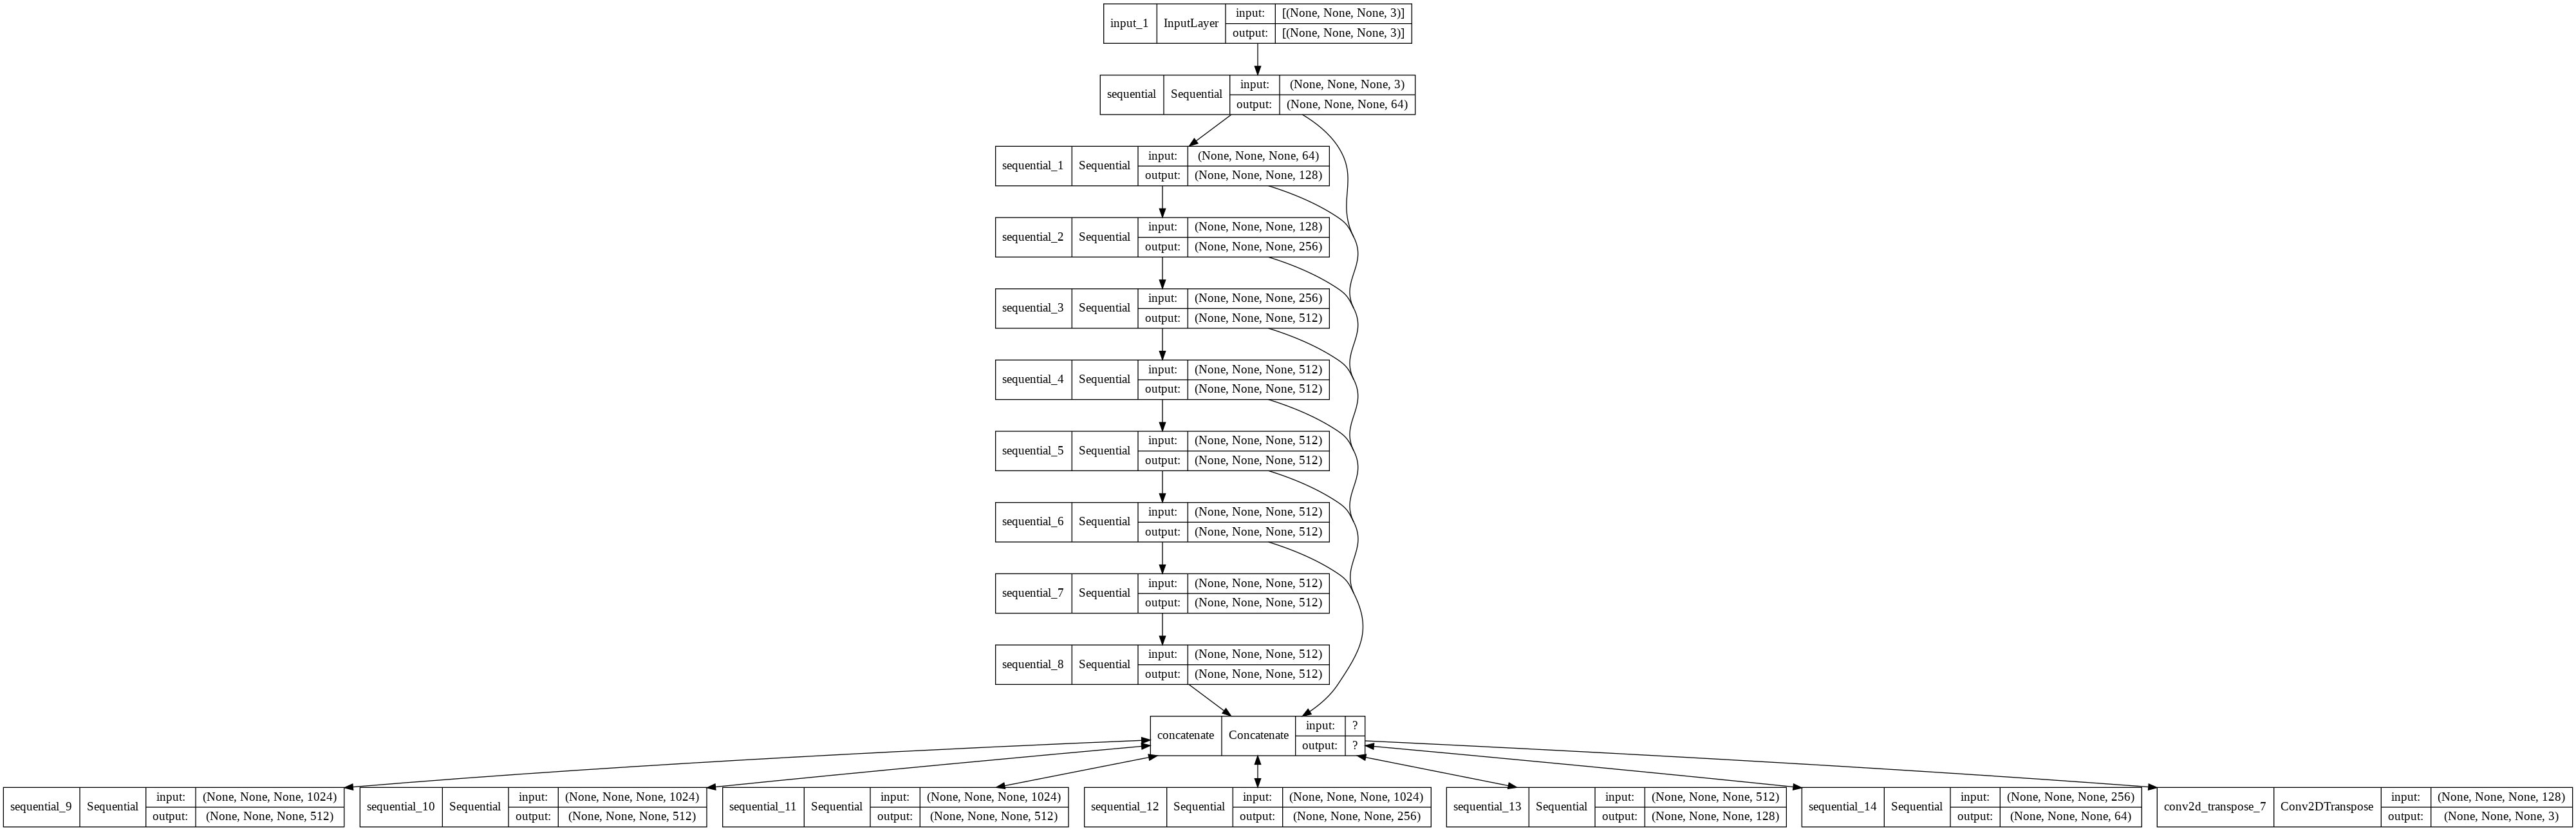

In [7]:
plot_model(generator_g, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Getting submodel for embedding space** 

In [8]:
l1 = generator_g.get_layer(name='concatenate')
emb = Model(generator_g.input, l1.output) 

In [9]:
emb.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                        

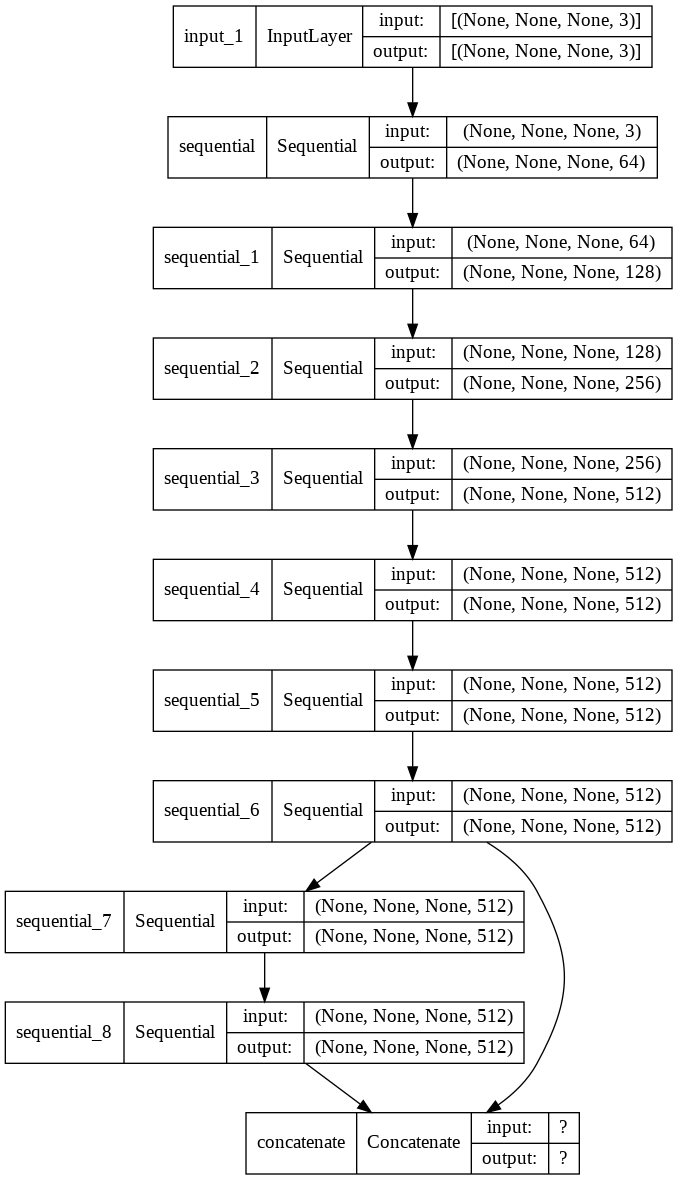

In [10]:
plot_model(emb, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Resolviendo el problema con capa concatenate...**

In [16]:
l1 = generator_g.get_layer(name='concatenate')
emb = Model(generator_g.input, l1.output)

#for solve problem
#inputs = keras.Input(shape=(295, 2, 2, 1024), name='img')
input = emb.output
x = layers.Reshape((4096,))(input)
emb2 = Model(inputs = emb.input, outputs = x)
emb2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                       

**Predicting...**

In [17]:
gen_path = "/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/preliminar data/test_WL"
imgs = os.listdir(gen_path)

img_height, img_width = 256, 256
video = []
imagen = []
label = []
pred = []

for img in imgs:
  clase = img.split('_')[0]
  vid = img.split('_')[3]
  img_ext = img.split('_')[-1]
  image = img_ext.split('.')[0]
  path = gen_path + '/' + img
  print("working on ", clase, " class...")

  img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = img_array* 1./255.
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  logits = emb2.predict(img_array, steps = 1)
  pred.extend(logits)
  video.append(vid)
  imagen.append(image)

  if clase == 'adenoma':    
    label.append('adenoma')
  elif clase == 'hiperplastic':
    label.append('hiperplastic')
  else:
    label.append('serrated')

#haciendo dataframe
df = pd.DataFrame(list(zip(video, imagen, label, pred)), columns=['#Video', '#imagen', 'clase', 'predicción'])
                
#pred = np.squeeze(pred, axis=1)
pred = np.array(pred)
print("dimension of predic: ", pred.shape)

#label = np.squeeze(label, axis=1)
label = np.array(label)
print("dimension of label: ", label.shape)

working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on  adenoma  class...
working on

# **Dimension reduction T-sne**

In [18]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
#from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
import plotly.express as px
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
import matplotlib

In [19]:
tsne = TSNE(n_components = 2, init = 'pca')
P1_tsne = tsne.fit_transform(pred)
P1_tsne.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



(295, 2)

In [20]:
l1 = P1_tsne[:,0]
l2 = P1_tsne[:,1]

In [21]:
df = df.drop(columns='predicción')
df['x'] = l1
df['y'] = l2

In [22]:
conditions = [
    (df['clase'] == 'adenoma'),
    (df['clase'] == 'hiperplastic'),
    (df['clase'] == 'serrated')
    ]

values = [1, 2, 3]

df['labels'] = np.select(conditions, values)

In [23]:
df.head()

,#Video,#imagen,clase,x,y,labels
0,10,19,adenoma,-7.185195,-12.876187,1
1,10,94,adenoma,-7.233533,-5.112095,1
2,10,361,adenoma,-11.115183,-2.434474,1
3,10,49,adenoma,-7.200965,-12.889337,1
4,10,121,adenoma,-9.609171,-2.711789,1


## **Overview**

In [32]:
fig = px.scatter(df, x="x", y="y", color = 'clase', hover_name="clase", hover_data=["#Video"])
fig.show()